<a href="https://colab.research.google.com/github/haonan2012/Dive2DeepLearning/blob/master/1_0_LinearRegression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

In [ ]:
import inspect

def add_to_class(Class):
  """Register functions as methods in created class."""
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper


class HyperParameters:
  """The base class of hyperparameters."""
  def save_hyperparameters(self, ignore=[]):
    """Save function arguments into class attributes."""
    frame = inspect.currentframe().f_back
    _, _, _, local_vars = inspect.getargvalues(frame)
    self.hparams = {k:v for k, v in local_vars.items()
            if k not in set(ignore+['self']) and not k.startswith('_')}
    for k, v in self.hparams.items():
      setattr(self, k, v)


from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import display
import collections

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

class ProgressBoard(HyperParameters):
  """The board that plots data points in animation."""
  def __init__(self, xlabel=None, ylabel=None, xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
        fig=None, axes=None, figsize=(3.5, 2.5), display=True):
    self.save_hyperparameters()
  def draw(self, x, y, label, every_n=1):
    Point = collections.namedtuple('Point', ['x', 'y'])
    if not hasattr(self, 'raw_points'):
      self.raw_points = collections.OrderedDict()
      self.data = collections.OrderedDict()
    if label not in self.raw_points:
      self.raw_points[label] = []
      self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
      return
    mean = lambda x: sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
            mean([p.y for p in points])))
    points.clear()
    if not self.display:
      return
    use_svg_display()
    if self.fig is None:
      self.fig = plt.figure(figsize=self.figsize)
    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
      plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                  linestyle=ls, color=color)[0])
      labels.append(k)
    axes = self.axes if self.axes else plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(self.fig)
    display.clear_output(wait=True)

# Data

In [ ]:
class DataModule(HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [ ]:
## from scratch
import torch
import random

class SyntheticRegressionData(DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise
    def get_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            # The examples are read in random order
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train+self.num_val))
        for i in range(0, len(indices), self.batch_size):
            batch_indices = torch.tensor(indices[i: i+self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]

In [ ]:
## using pytorch API
import torch
import random

class SyntheticRegressionData(DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

In [ ]:
data = SyntheticRegressionData(w=torch.tensor([2.5,3.3]), b=5, num_train=5, num_val=2)
train = data.train_dataloader()

In [ ]:
next(iter(train))

[tensor([[-0.3385,  0.7278],
         [ 0.3778,  0.0453],
         [-0.1162,  0.5206],
         [ 1.5670, -0.2558],
         [ 0.0136, -0.1803]]),
 tensor([[6.5616],
         [6.1048],
         [6.4468],
         [8.0790],
         [4.4289]])]

# Model

In [ ]:
from torch import nn

class Module(nn.Module, HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.cpu().detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [ ]:
class LinearRegressionScratch(Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()


In [ ]:
class SGD(HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

# Training

In [ ]:
class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                      if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

In [ ]:
@add_to_class(Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(batch)
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(batch)
        self.val_batch_idx += 1

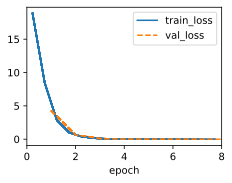

In [ ]:
model = LinearRegressionScratch(3, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4, 5.2]), b=4.2)
trainer = Trainer(max_epochs=8)
trainer.fit(model, data)

In [ ]:
print(f'error in estimating w: {data.w - model.w.data.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b.data}')

error in estimating w: tensor([ 0.0008, -0.0016,  0.0019])
error in estimating b: tensor([0.0023])


# Weight Decay

In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr):
        super().__init__(num_inputs, lr)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [ ]:
num_inputs = 200
w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
data = SyntheticRegressionData(w, b, num_train=20, num_val=100, batch_size=5)

In [ ]:
trainer = Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010970104485750198


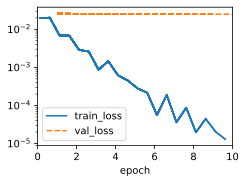

In [ ]:
train_scratch(0)

L2 norm of w: 0.001368077821098268


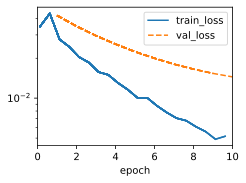

In [ ]:
train_scratch(3)